---

This notebook will recreate Dr. Davila's research paper, [Estimating the stability number of a random graph using convolutional neural networks](http://arxiv.org/pdf/2407.07827), but will instead use CNNs to predict the domination number of a graph. We will make use of the graphcalc library to streamline parts of the code, since it contains functions to perform many of the necessary computations on graphs.

---

In [10]:
# Import necessary packages:
import graphcalc as gc
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image


In [11]:
# Function to convert adjacency matrix and heatmap to fixed-size image.
def convert_to_heatmap_image(G, target_size=64):
    adj_matrix = nx.to_numpy_array(G)
    matrix_size = adj_matrix.shape[0]

    if matrix_size < target_size:
        padded_matrix = np.zeros((target_size, target_size), dtype=int)
        padded_matrix[:matrix_size, :matrix_size] = adj_matrix
    elif matrix_size > target_size:
        image = Image.fromarray(adj_matrix)
        padded_matrix = np.array(image.resize((target_size, target_size), Image.BILINEAR))
    else:
        padded_matrix = adj_matrix

    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict[node] for node in G.nodes()])
    heatmap = np.zeros((target_size, target_size), dtype=float)

    for i, node in enumerate(G.nodes()):
        if i < target_size:
            heatmap[i, i] = degrees[i]

    combined_matrix = padded_matrix + heatmap
    combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)

    return Image.fromarray(combined_image, 'L')

# Function to generate random graphs and calculate their domination number.
def generate_domination_number_data(num_graphs, max_nodes):
    graphs = []
    domination_numbers = []
    for _ in range(num_graphs):
        num_nodes = random.randint(5, max_nodes)
        G = nx.gnp_random_graph(num_nodes, np.random.rand())
        ind_num = gc.domination_number(G)
        graphs.append(G)
        domination_numbers.append(ind_num)
    return graphs, domination_numbers

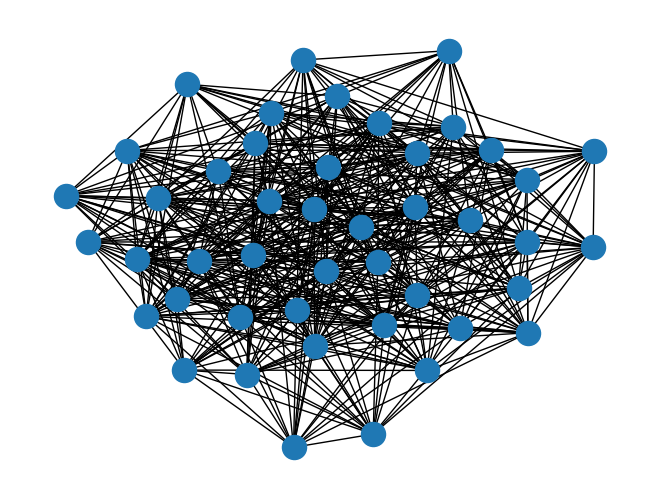

In [12]:
G = nx.gnp_random_graph(45, 0.5)
nx.draw(G)
plt.show()

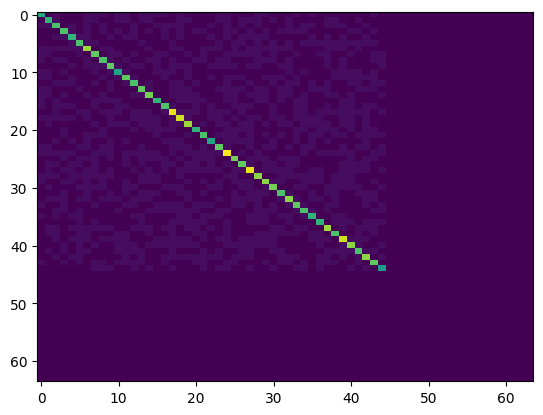

In [13]:
image = convert_to_heatmap_image(G)
plt.imshow(image, cmap='viridis', aspect='auto')
plt.show()

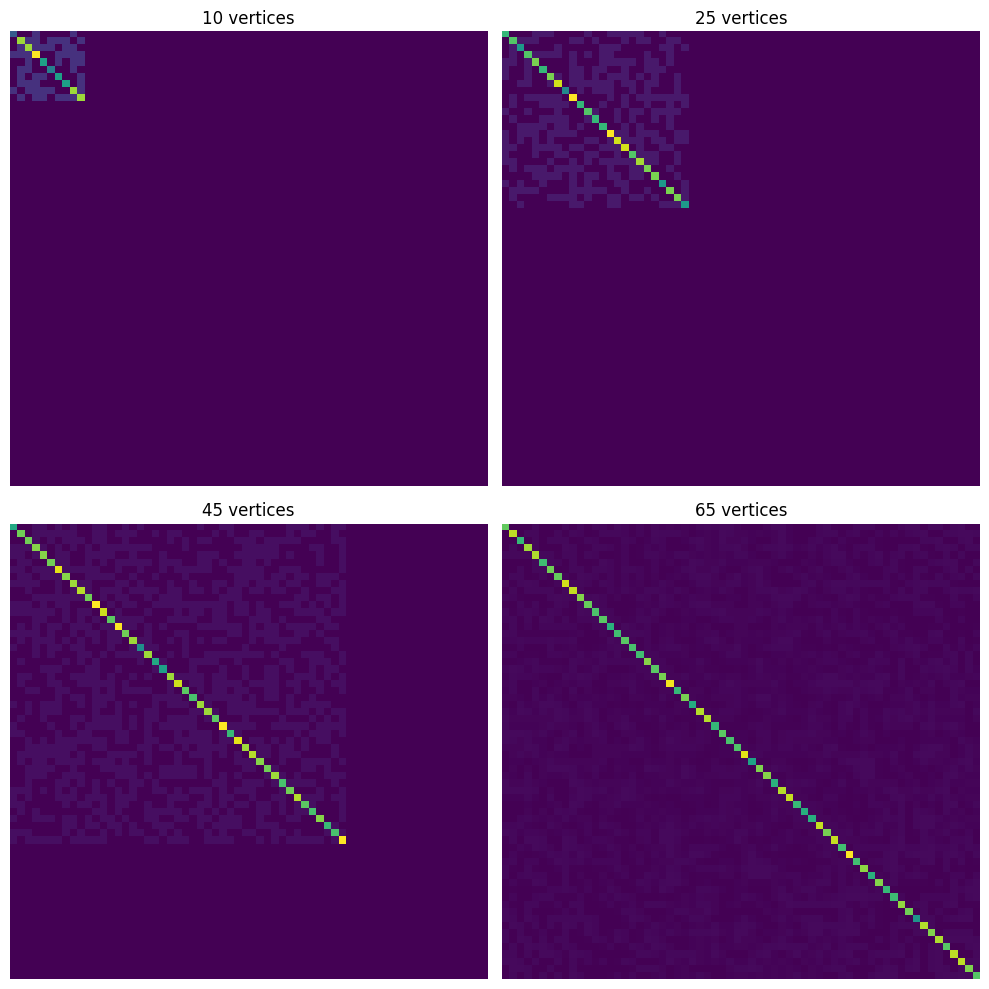

In [14]:
# Create graphs with different numbers of vertices
graphs = [
    nx.gnp_random_graph(10, 0.5),
    nx.gnp_random_graph(25, 0.5),
    nx.gnp_random_graph(45, 0.5),
    nx.gnp_random_graph(65, 0.5)
]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the subplots
titles = ['10 vertices', '25 vertices', '45 vertices', '65 vertices']

for i, (G, ax) in enumerate(zip(graphs, axs.flatten())):
    image = convert_to_heatmap_image(G)
    ax.imshow(image, cmap='viridis', aspect='auto')
    ax.set_title(titles[i])
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

In [15]:
# Generate dataset of 2,000 random graphs with varying node sizes 10 <= n <= 64.
num_graphs = 2_000
max_nodes = 64
graphs, domination_numbers = generate_domination_number_data(num_graphs, max_nodes)

# Convert graphs to images.
target_size = 64
images = [convert_to_heatmap_image(graph, target_size) for graph in graphs]
X = np.array([np.array(image).reshape(target_size, target_size, 1) for image in images])
y = np.array(domination_numbers)

# Split dataset into training and testing.
split_index = int(0.8 * num_graphs)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

C:\Users\kylej\AppData\Local\Temp\ipykernel_19440\663588745.py:24: RuntimeWarning: invalid value encountered in divide
  combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)
C:\Users\kylej\AppData\Local\Temp\ipykernel_19440\663588745.py:24: RuntimeWarning: invalid value encountered in cast
  combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)


In [16]:
from tensorflow.keras import layers, models

# Define the CNN model.
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

# Instantiate and train the model.
input_shape = (target_size, target_size, 1)
model = create_model(input_shape)
model.summary()
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

c:\Users\kylej\OneDrive\Documents\Schoolwork\Research\graphs\CNN-domination-number\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,697 (2.46 MB)

 Trainable params: 645,697 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 236.5051 - mae: 6.6577 - val_loss: 15.3873 - val_mae: 1.7257
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 12.7558 - mae: 2.0561 - val_loss: 11.1721 - val_mae: 1.5762
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 5.6674 - mae: 1.2460 - val_loss: 8.7269 - val_mae: 1.3991
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3070 - mae: 0.9859 - val_loss: 9.6094 - val_mae: 1.1654
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4250 - mae: 0.9427 - val_loss: 9.3925 - val_mae: 1.4638
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4891 - mae: 1.1021 - val_loss: 11.5848 - val_mae: 1.0925
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9720 - mae: 0.7674 - val_loss: 8.8261 - val_mae: 0.9800
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.1341 - mae: 0.5944 - val_loss: 7.6993 - val_mae: 1.0126
Epoch 9/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss:

In [17]:
# Evaluate the model.
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8467 - mae: 0.8064 
Test MAE: 0.8719152212142944


In [26]:
# Generate a random graph with n nodes.
n = 30
G = nx.gnp_random_graph(n, np.random.rand())

# Convert adjacency matrix to image with heatmap.
adj_image = convert_to_heatmap_image(G)

# Prepare the image for the model.
input_image = np.array(adj_image).reshape(1, 64, 64, 1)  # Add batch dimension and channel dimension.

# Predict the domination number using the trained CNN.
predicted_domination_number = model.predict(input_image)
print(f"Predicted domination number for the {n}-node graph: {predicted_domination_number[0][0]}")

# Compute the actual domination number using linear-integer programming for comparison.
actual_domination_number = gc.domination_number(G)
print(f"Computed domination number for the {n}-node graph: {actual_domination_number}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted domination number for the 30-node graph: 2.099745273590088
Computed domination number for the 30-node graph: 2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

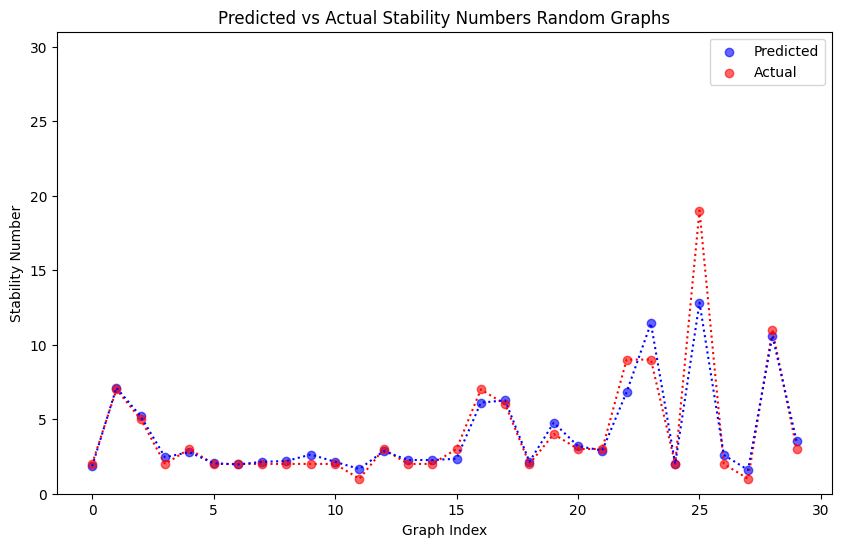

<Figure size 640x480 with 0 Axes>

In [27]:
import pandas as pd
# Generate and process multiple random graphs
num_graphs = 30
num_nodes = 30
results = []

for _ in range(num_graphs):
    G = nx.gnp_random_graph(n, np.random.rand())

    # Convert adjacency matrix to image with heatmap
    adj_image = convert_to_heatmap_image(G)

    # Prepare the image for the model
    input_image = np.array(adj_image).reshape(1, 64, 64, 1)  # Add batch dimension and channel dimension

    # Predict the domination number using the trained CNN
    predicted_domination_number = model.predict(input_image)[0][0]

    # Compute the actual domination number
    actual_domination_number = gc.domination_number(G)

    # Store the results
    results.append({
        "Graph Index": _,
        "Predicted Domination Number": predicted_domination_number,
        "Actual Domination Number": actual_domination_number
    })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Display the results as a table
print(results_df)

# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df["Graph Index"], results_df["Predicted Domination Number"], label="Predicted", color='blue', alpha=0.6)
plt.scatter(results_df["Graph Index"], results_df["Actual Domination Number"], label="Actual", color='red', alpha=0.6)
plt.plot(results_df["Graph Index"], results_df["Actual Domination Number"], color='red', linestyle='dotted')
plt.plot(results_df["Graph Index"], results_df["Predicted Domination Number"], color='blue', linestyle='dotted')
plt.xlabel("Graph Index")
plt.ylabel("Stability Number")
plt.title("Predicted vs Actual Stability Numbers Random Graphs")
plt.ylim(0, num_nodes+1)
plt.legend()
plt.show()

# Optionally, save the figure
plt.savefig("stability_number_prediction_comparison.png")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test MSE: 6.612720489501953
Test MAE: 0.8719152212142944
Test RMSE: 2.5715210458990905
Test R-squared: 0.7704713940620422
95% Confidence Interval for the Predictions: (np.float64(3.9445304636781064), np.float64(4.908963226812617))


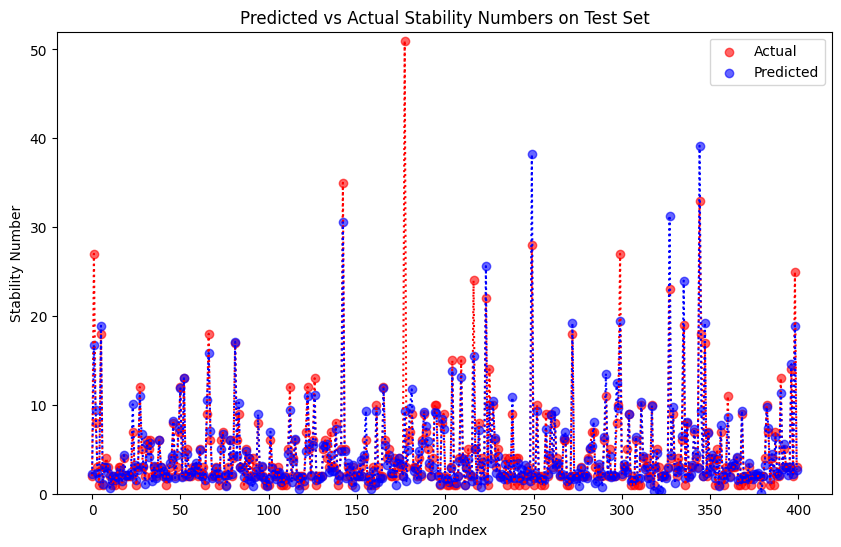

<Figure size 640x480 with 0 Axes>

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate the model on the test set
y_pred = model.predict(X_test).flatten()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_val = rmse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse_val}')
print(f'Test R-squared: {r2}')

# Calculate 95% confidence intervals for the predictions
conf_interval = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(y_pred), scale=stats.sem(y_pred))
print(f'95% Confidence Interval for the Predictions: {conf_interval}')

# Display results in a DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color='red', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred, label="Predicted", color='blue', alpha=0.6)
plt.plot(range(len(y_test)), y_test, color='red', linestyle='dotted')
plt.plot(range(len(y_test)), y_pred, color='blue', linestyle='dotted')
plt.xlabel("Graph Index")
plt.ylabel("Stability Number")
plt.title("Predicted vs Actual Stability Numbers on Test Set")
plt.ylim(0, max(y_test) + 1)
plt.legend()
plt.show()

# Optionally, save the figure
plt.savefig("stability_number_prediction_comparison_test_set.png")
